<a href="https://colab.research.google.com/github/buketugurlu/dentaLyze/blob/main/yolov11_deneme3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Ultralytics (YOLO) paketini yükle
!pip install ultralytics

# Albumentations ve OpenCV paketlerini yükle
!pip install albumentations opencv-python-headless


In [17]:
pip install -U albumentations

In [19]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [38]:
from ultralytics import YOLO
import os
import yaml
import cv2
from albumentations import Compose, HorizontalFlip, ShiftScaleRotate, Affine

In [21]:
# 1. Dataset YAML dosyasını oluşturma
dataset_yaml_path = "/content/drive/MyDrive/Dental OPG XRAY Dataset/dataset.yaml"
yaml_dir = os.path.dirname(dataset_yaml_path)

# Dizini kontrol et ve gerekirse oluştur
os.makedirs(yaml_dir, exist_ok=True)
yaml_content = {
    "path": "/content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data",
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": 6,
    "names": ['Healthy Teeth', 'Caries', 'Impacted Teeth', 'BDC/BDR', 'Infection', 'Fractured Teeth']
}

In [22]:
# YAML dosyasını kaydet
with open(dataset_yaml_path, "w") as yaml_file:
    yaml.dump(yaml_content, yaml_file)

print(f"Dataset YAML dosyası oluşturuldu: {dataset_yaml_path}")

Dataset YAML dosyası oluşturuldu: /content/drive/MyDrive/Dental OPG XRAY Dataset/dataset.yaml


In [24]:
# CLAHE İşleme
def apply_clahe(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for img_file in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_file)
        output_path = os.path.join(output_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_img = clahe.apply(img)
        cv2.imwrite(output_path, enhanced_img)

In [25]:
# Augmentasyon
def augment_image(image_path, save_path):
    image = cv2.imread(image_path)
    transform = Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.7),
        Affine(shear=15, p=0.5),
    ])
    augmented = transform(image=image)
    cv2.imwrite(save_path, augmented["image"])

In [26]:
# Modeli Eğitme
def train_model():
    model = YOLO('yolov8n.pt')
    model.train(
        data=dataset_yaml_path,
        epochs=100,
        batch=16,
        imgsz=640,
        name='dental_detection',
        plots=True
    )

In [27]:
# Tahmin
def predict_images():
    model = YOLO('runs/train/dental_detection/weights/best.pt')
    results = model.predict(
        source='/content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/test/images',
        conf=0.25,
        save=True,
        save_txt=True,
        save_conf=True
    )
    return results

In [28]:
# Ana Fonksiyon
def main():
    try:
        input_dir = "/content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/train/images"
        clahe_dir = "/content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/train/images_clahe"
        augmented_dir = "/content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/train/images_augmented"

        print("CLAHE uygulanıyor...")
        apply_clahe(input_dir, clahe_dir)
        print("Augmentasyon uygulanıyor...")
        os.makedirs(augmented_dir, exist_ok=True)
        for img_file in os.listdir(clahe_dir):
            augment_image(os.path.join(clahe_dir, img_file), os.path.join(augmented_dir, img_file))

        print("Eğitim başlatılıyor...")
        train_model()

        print("Tahmin başlatılıyor...")
        results = predict_images()
        print("Tahmin tamamlandı.")
    except Exception as e:
        print(f"Hata oluştu: {e}")

if __name__ == "__main__":
    main()

CLAHE uygulanıyor...
Augmentasyon uygulanıyor...
Eğitim başlatılıyor...


100%|██████████| 6.25M/6.25M [00:00<00:00, 77.8MB/s]


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Dental OPG XRAY Dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=dental_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

100%|██████████| 755k/755k [00:00<00:00, 13.3MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.7MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/train/labels... 2878 images, 9 backgrounds, 0 corrupt: 100%|██████████| 2887/2887 [01:36<00:00, 29.93it/s]


train: New cache created: /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:01<00:00, 15.66it/s]

val: New cache created: /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/valid/labels.cache


Plotting labels to runs/detect/dental_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/dental_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.32G      2.764      3.721      2.068         75        640: 100%|██████████| 181/181 [00:21<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         23        115      0.472        0.1      0.124     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.27G      2.452      3.177      1.824         74        640: 100%|██████████| 181/181 [00:19<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         23        115      0.485      0.175      0.148     0.0728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.36G        2.4      3.091      1.813         86        640: 100%|██████████| 181/181 [00:18<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         23        115      0.451      0.215      0.165     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.28G      2.338      3.013      1.793         76        640: 100%|██████████| 181/181 [00:18<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         23        115      0.496      0.134      0.191     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.36G      2.334      2.979      1.796         71        640: 100%|██████████| 181/181 [00:18<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         23        115      0.291      0.201      0.183     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.31G      2.286      2.912      1.769         90        640: 100%|██████████| 181/181 [00:18<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         23        115       0.56      0.269      0.234      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.27G      2.252      2.877      1.759         78        640: 100%|██████████| 181/181 [00:18<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         23        115      0.641      0.246      0.281      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.3G      2.232      2.857       1.75         77        640: 100%|██████████| 181/181 [00:18<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         23        115      0.576      0.282       0.31       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.39G       2.22      2.809      1.734        101        640: 100%|██████████| 181/181 [00:18<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         23        115      0.599      0.406      0.307      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.3G      2.213      2.824      1.738         76        640: 100%|██████████| 181/181 [00:18<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         23        115      0.542      0.308      0.256      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.29G      2.181      2.781      1.718         82        640: 100%|██████████| 181/181 [00:18<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]

                   all         23        115      0.608      0.324      0.312      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.28G      2.163      2.752      1.707         60        640: 100%|██████████| 181/181 [00:18<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         23        115      0.472      0.372      0.331      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.36G       2.15      2.728      1.685         50        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         23        115      0.579      0.365      0.307      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.31G      2.143      2.709      1.692         94        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         23        115      0.647      0.331      0.336      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.32G      2.148      2.711      1.695         71        640: 100%|██████████| 181/181 [00:18<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]

                   all         23        115      0.618      0.366      0.333       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.28G      2.109      2.665      1.665         47        640: 100%|██████████| 181/181 [00:18<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         23        115      0.685      0.384      0.387      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.37G      2.112       2.67      1.668         98        640: 100%|██████████| 181/181 [00:18<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         23        115      0.477      0.432      0.389      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.28G      2.096      2.643      1.663         73        640: 100%|██████████| 181/181 [00:18<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         23        115       0.73      0.426      0.423      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.32G      2.078      2.615      1.661         96        640: 100%|██████████| 181/181 [00:18<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         23        115      0.476       0.43       0.41      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.3G      2.086      2.623      1.656         62        640: 100%|██████████| 181/181 [00:18<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         23        115      0.671      0.415      0.439      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.39G      2.059       2.58      1.643         66        640: 100%|██████████| 181/181 [00:18<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23        115      0.353       0.51      0.423      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.41G      2.061      2.578      1.646         85        640: 100%|██████████| 181/181 [00:18<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         23        115      0.432      0.575      0.514      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.3G      2.063      2.585      1.645         84        640: 100%|██████████| 181/181 [00:18<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         23        115      0.336      0.468      0.366      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.31G      2.063      2.596       1.66         86        640: 100%|██████████| 181/181 [00:18<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         23        115      0.455      0.492      0.495      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.35G       2.05      2.553       1.64         70        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         23        115      0.572      0.385      0.394      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.31G      2.018       2.54      1.633         98        640: 100%|██████████| 181/181 [00:18<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         23        115      0.484      0.488      0.471      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.29G      2.019      2.526      1.622         88        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         23        115      0.617      0.518      0.518      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       2.3G      2.031      2.521      1.624         92        640: 100%|██████████| 181/181 [00:18<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         23        115      0.335      0.579      0.468      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.37G      1.992      2.474      1.603         63        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         23        115      0.574      0.423      0.458      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.28G      2.003      2.493      1.608        110        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         23        115      0.635      0.542      0.496       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.3G      1.989      2.469      1.605         58        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         23        115      0.472      0.462      0.472      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.28G      1.986      2.451      1.594         63        640: 100%|██████████| 181/181 [00:18<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         23        115      0.659      0.506      0.534      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.37G      1.978      2.445      1.589         73        640: 100%|██████████| 181/181 [00:18<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         23        115      0.456      0.624      0.509       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.26G      1.976      2.443      1.603         79        640: 100%|██████████| 181/181 [00:18<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         23        115      0.813      0.383      0.465      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.27G      1.975      2.434      1.593         94        640: 100%|██████████| 181/181 [00:18<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         23        115      0.525      0.501      0.518      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.28G      1.949      2.396      1.574         65        640: 100%|██████████| 181/181 [00:18<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         23        115      0.549      0.587      0.538      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.36G      1.951      2.409      1.577        132        640: 100%|██████████| 181/181 [00:18<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         23        115      0.741      0.506      0.603      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.31G      1.943      2.407      1.578         90        640: 100%|██████████| 181/181 [00:18<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.684      0.463      0.529      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.28G       1.95      2.403      1.569         70        640: 100%|██████████| 181/181 [00:18<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         23        115      0.619      0.583      0.565      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.29G      1.929      2.374       1.56         75        640: 100%|██████████| 181/181 [00:18<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         23        115      0.659      0.521      0.508      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.34G      1.912      2.363      1.558         51        640: 100%|██████████| 181/181 [00:18<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         23        115      0.535      0.636      0.591       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.29G      1.911      2.334      1.557         88        640: 100%|██████████| 181/181 [00:18<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

                   all         23        115      0.433      0.652      0.528      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.3G      1.916      2.355       1.56         62        640: 100%|██████████| 181/181 [00:18<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         23        115      0.423       0.59       0.53      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.28G      1.897      2.326      1.542         59        640: 100%|██████████| 181/181 [00:18<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         23        115      0.685      0.623      0.591      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.36G      1.904      2.319      1.554         76        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         23        115      0.837      0.494      0.574      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.31G      1.894      2.317      1.544         85        640: 100%|██████████| 181/181 [00:18<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         23        115      0.558      0.529      0.565      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.29G        1.9      2.317      1.551         64        640: 100%|██████████| 181/181 [00:18<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all         23        115       0.71      0.522      0.542      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.28G      1.889      2.328      1.545         72        640: 100%|██████████| 181/181 [00:18<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         23        115      0.637      0.593       0.59      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.36G      1.885      2.309      1.538         86        640: 100%|██████████| 181/181 [00:18<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         23        115      0.716      0.577      0.594      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.29G      1.874      2.284      1.529         94        640: 100%|██████████| 181/181 [00:18<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         23        115      0.514      0.628      0.563       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.26G      1.864      2.279      1.534         61        640: 100%|██████████| 181/181 [00:18<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         23        115      0.574      0.681       0.63       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.26G       1.87      2.265      1.527         80        640: 100%|██████████| 181/181 [00:18<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         23        115      0.532      0.544      0.578      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.35G      1.848      2.251      1.519         70        640: 100%|██████████| 181/181 [00:18<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         23        115       0.73      0.523      0.572      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.29G      1.859      2.268      1.527         63        640: 100%|██████████| 181/181 [00:18<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         23        115      0.481      0.665      0.591      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.28G      1.833      2.226      1.508         61        640: 100%|██████████| 181/181 [00:18<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]

                   all         23        115        0.6      0.674      0.619      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.28G      1.827      2.212      1.502         55        640: 100%|██████████| 181/181 [00:18<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         23        115      0.616      0.611      0.639      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.32G      1.839      2.241      1.514         69        640: 100%|██████████| 181/181 [00:18<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         23        115      0.531      0.618      0.573      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.41G      1.837      2.216      1.511         91        640: 100%|██████████| 181/181 [00:18<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         23        115      0.555      0.624      0.578      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.29G      1.834      2.212      1.502         65        640: 100%|██████████| 181/181 [00:18<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         23        115      0.477      0.645      0.574      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.23G       1.83      2.228      1.509         84        640: 100%|██████████| 181/181 [00:18<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         23        115      0.853      0.539      0.636      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.36G       1.81      2.195      1.496         69        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115      0.687      0.623      0.613      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.28G      1.811      2.181      1.496         87        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]

                   all         23        115      0.692      0.667      0.664      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.26G      1.806      2.157      1.489         76        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         23        115      0.569      0.676      0.632      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.29G      1.797      2.158      1.484         54        640: 100%|██████████| 181/181 [00:18<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         23        115      0.663      0.631      0.657      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.34G      1.785      2.159      1.485         49        640: 100%|██████████| 181/181 [00:18<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         23        115      0.822      0.626      0.673      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.3G      1.801      2.175      1.489         76        640: 100%|██████████| 181/181 [00:18<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         23        115      0.821      0.591      0.638      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.29G      1.802       2.15       1.48        115        640: 100%|██████████| 181/181 [00:18<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         23        115      0.897      0.574      0.655      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.3G      1.776      2.111      1.462         71        640: 100%|██████████| 181/181 [00:18<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         23        115      0.595      0.719      0.655      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.35G      1.782      2.127      1.475        103        640: 100%|██████████| 181/181 [00:18<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         23        115      0.681      0.704      0.686      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.27G      1.772      2.122      1.472         92        640: 100%|██████████| 181/181 [00:18<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         23        115      0.671      0.685      0.657      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.3G       1.78      2.132      1.474         89        640: 100%|██████████| 181/181 [00:18<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         23        115      0.632      0.703      0.654      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.31G      1.766       2.12      1.457         53        640: 100%|██████████| 181/181 [00:18<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         23        115      0.787      0.657      0.667      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.38G      1.767      2.115      1.465         95        640: 100%|██████████| 181/181 [00:18<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]

                   all         23        115      0.819      0.565      0.651      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.3G      1.753        2.1      1.452         95        640: 100%|██████████| 181/181 [00:18<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         23        115      0.653      0.692      0.662      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.27G      1.757      2.095      1.455         74        640: 100%|██████████| 181/181 [00:18<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         23        115      0.841      0.604      0.652      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.3G      1.747      2.074      1.448         73        640: 100%|██████████| 181/181 [00:18<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         23        115      0.639      0.707      0.677      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.34G      1.752      2.095       1.45         80        640: 100%|██████████| 181/181 [00:18<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         23        115      0.755      0.693       0.68      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.27G      1.737      2.093       1.45         74        640: 100%|██████████| 181/181 [00:18<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         23        115      0.691      0.661      0.694      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.29G      1.743       2.08      1.441         87        640: 100%|██████████| 181/181 [00:18<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         23        115       0.81      0.609      0.661      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.27G       1.72      2.047      1.437         83        640: 100%|██████████| 181/181 [00:18<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         23        115      0.795      0.664      0.686      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.38G      1.722      2.062      1.442         71        640: 100%|██████████| 181/181 [00:18<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.634      0.701      0.677      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.32G      1.724      2.052      1.439         75        640: 100%|██████████| 181/181 [00:18<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         23        115      0.713      0.689      0.691      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.31G      1.732      2.082      1.444         56        640: 100%|██████████| 181/181 [00:18<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]

                   all         23        115      0.858        0.6      0.685      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.31G      1.704      2.026      1.423         83        640: 100%|██████████| 181/181 [00:18<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]

                   all         23        115       0.73      0.692        0.7      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.36G      1.698      2.026      1.427         72        640: 100%|██████████| 181/181 [00:18<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         23        115      0.805      0.692      0.713      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.27G      1.701       2.02      1.421         68        640: 100%|██████████| 181/181 [00:18<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         23        115      0.647      0.719      0.701      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.31G      1.714      2.038       1.43         60        640: 100%|██████████| 181/181 [00:18<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         23        115      0.813      0.673      0.714      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.27G      1.697       2.02      1.423         69        640: 100%|██████████| 181/181 [00:18<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         23        115      0.754      0.683      0.705      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.34G      1.692      2.002      1.414         90        640: 100%|██████████| 181/181 [00:18<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         23        115      0.748      0.687      0.726      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.27G      1.677      2.006       1.42         93        640: 100%|██████████| 181/181 [00:18<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         23        115      0.793      0.669       0.71      0.432


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.27G      1.691       2.13      1.517         67        640: 100%|██████████| 181/181 [00:19<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         23        115      0.618      0.717      0.706      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.23G      1.657      2.084      1.502         35        640: 100%|██████████| 181/181 [00:18<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         23        115      0.704      0.697      0.698      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.31G      1.637      2.057      1.488         51        640: 100%|██████████| 181/181 [00:18<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         23        115      0.621      0.724      0.702       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.24G      1.638      2.059      1.489         54        640: 100%|██████████| 181/181 [00:18<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         23        115      0.612      0.724      0.691      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.24G      1.634      2.054      1.485         41        640: 100%|██████████| 181/181 [00:18<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         23        115      0.671      0.719      0.707      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.23G      1.628      2.041      1.479         57        640: 100%|██████████| 181/181 [00:18<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         23        115      0.611      0.727      0.696      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.32G      1.622      2.028      1.477         40        640: 100%|██████████| 181/181 [00:18<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

                   all         23        115      0.645      0.717      0.716      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.27G      1.618      2.024       1.48         32        640: 100%|██████████| 181/181 [00:18<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         23        115      0.621      0.717      0.685      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.24G      1.614      2.017      1.468         54        640: 100%|██████████| 181/181 [00:18<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

                   all         23        115      0.592      0.717      0.714      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.23G      1.616       2.02      1.473         40        640: 100%|██████████| 181/181 [00:18<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         23        115      0.611      0.717      0.713      0.427



100 epochs completed in 0.539 hours.
Optimizer stripped from runs/detect/dental_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/dental_detection/weights/best.pt, 6.2MB

Validating runs/detect/dental_detection/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


                   all         23        115      0.805      0.688      0.713      0.449
         Healthy Teeth          8         14      0.781      0.766      0.764      0.568
                Caries          3          4      0.842       0.25       0.35     0.0875
        Impacted Teeth          7         18      0.987          1      0.995      0.618
               BDC/BDR          3          3      0.815      0.667      0.671      0.471
             Infection          6          9      0.897          1      0.984        0.6
       Fractured Teeth         22         67      0.508      0.447      0.516       0.35
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/dental_detection
Tahmin başlatılıyor...
Hata oluştu: [Errno 2] No such file or directory: 'runs/train/dental_detection/weights/best.pt'


In [32]:
model = YOLO('runs/detect/dental_detection/weights/best.pt')  # Doğru ağırlık yolu
results = model.predict(
    source='/content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/test/images',
    conf=0.25,
    save=True,
    save_txt=True,
    save_conf=True
)



image 1/23 /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/test/images/104_jpg.rf.05501644f89b63b3f9ba38f2c2436c75.jpg: 352x640 1 Healthy Teeth, 1 Impacted Teeth, 2 Fractured Teeths, 47.0ms
image 2/23 /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/test/images/106_jpg.rf.55f75c16fffc0fea03b260bf91b8fc68.jpg: 352x640 2 Infections, 2 Fractured Teeths, 8.0ms
image 3/23 /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/test/images/127_jpg.rf.c6c7a6eea86965354399e338b71fbc6a.jpg: 288x640 1 Impacted Teeth, 5 Fractured Teeths, 46.9ms
image 4/23 /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/test/images/143_jpg.rf.d7f7764bed646dc8d58806a732ef86f4.jpg: 352x640 3 Fractured Teeths, 9.3ms
image 5/23 /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Data/test/images/146_jpg.rf.416fe5cb77bd045aedfc942be5392ff6.jpg: 320x640 2 Healthy Teeths, 2 Fractured Teeths, 47.5ms
image 6/23 /content/drive/MyDrive/Dental OPG XRAY Dataset/Augmented_Dat

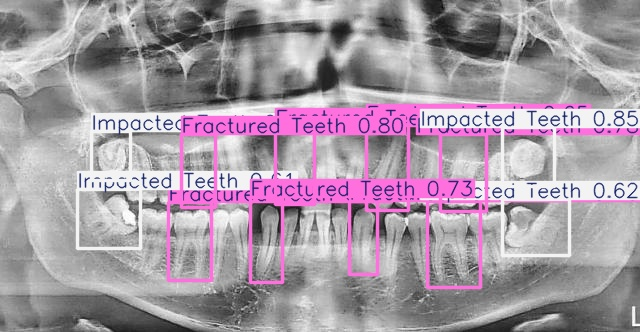

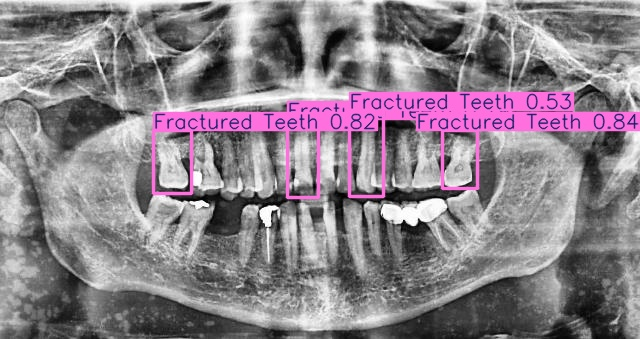

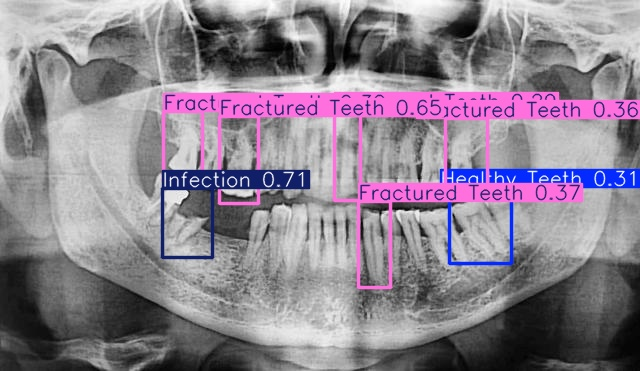

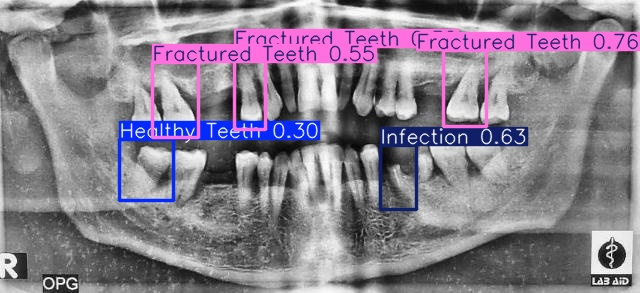

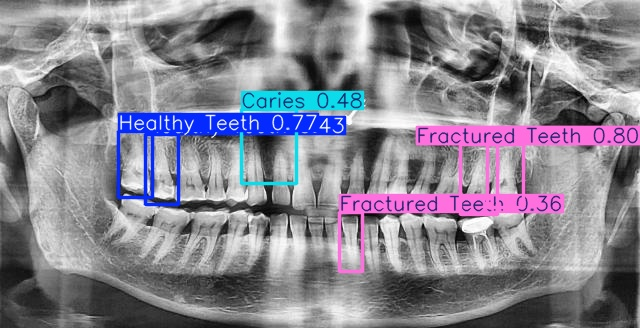

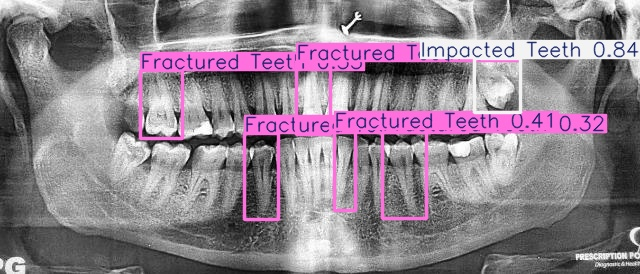

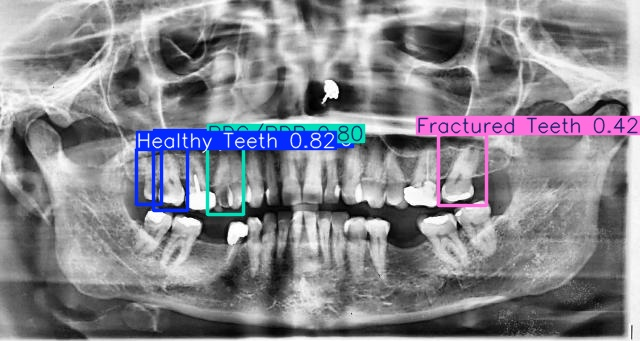

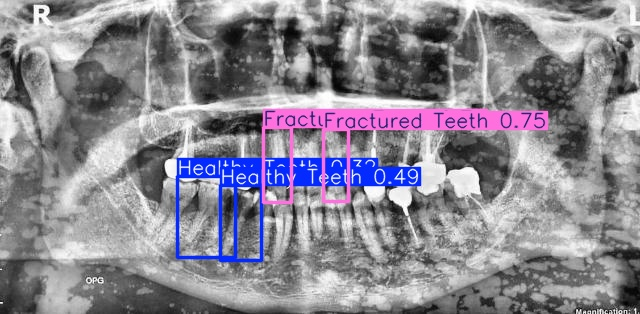

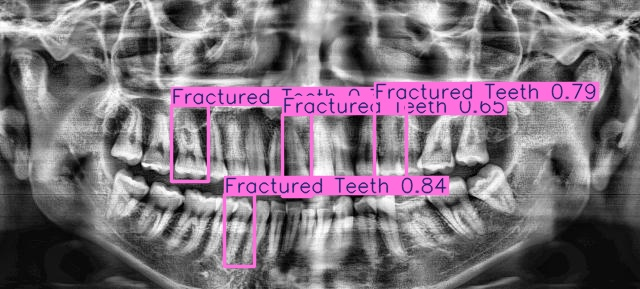

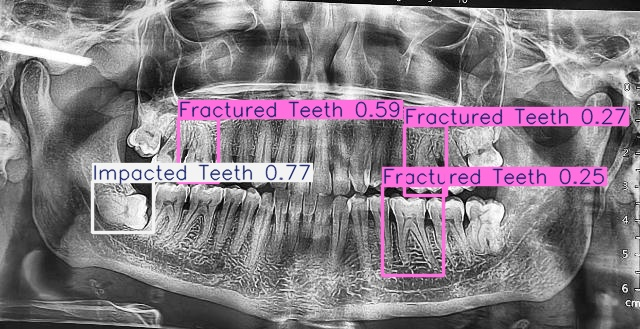

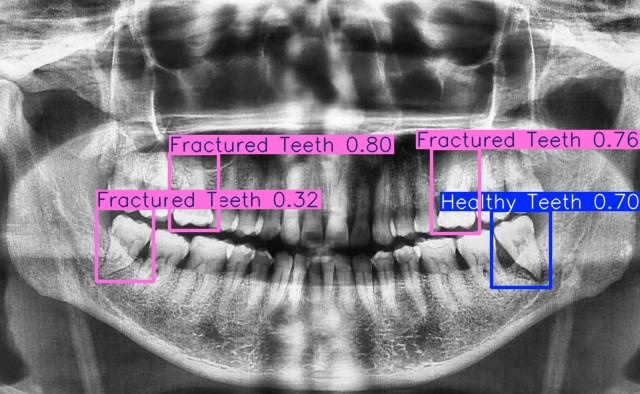

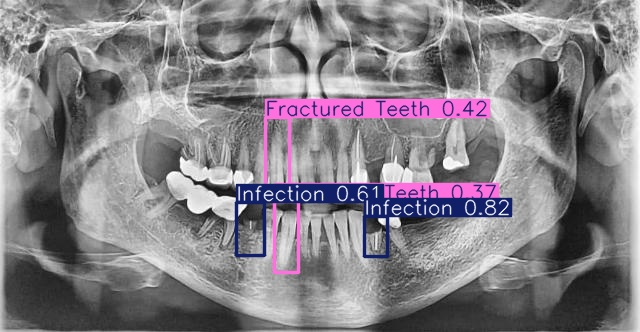

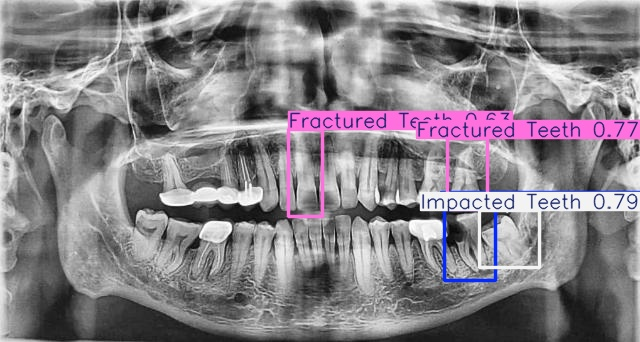

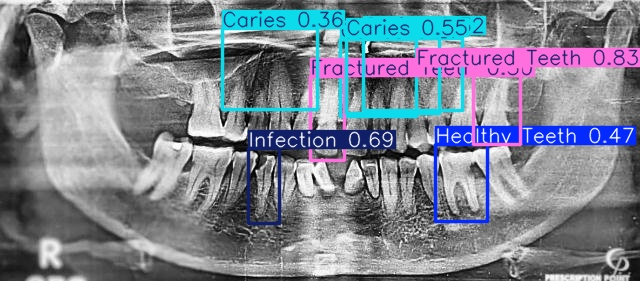

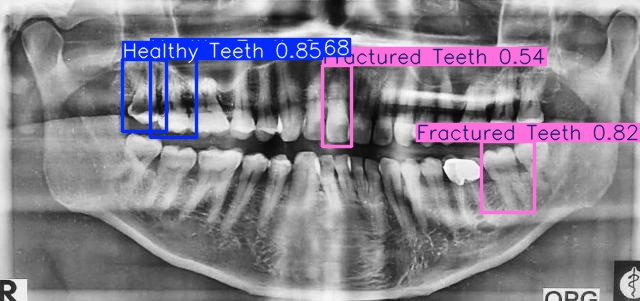

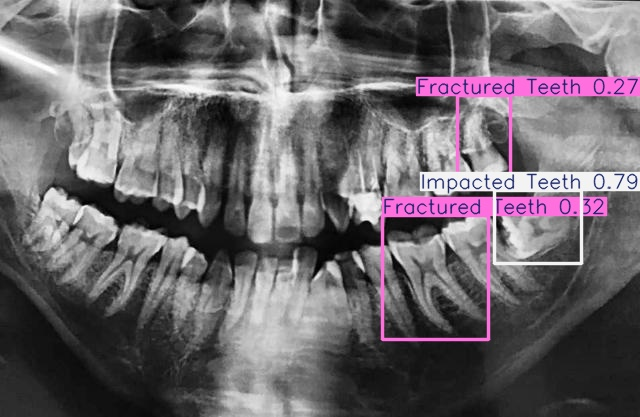

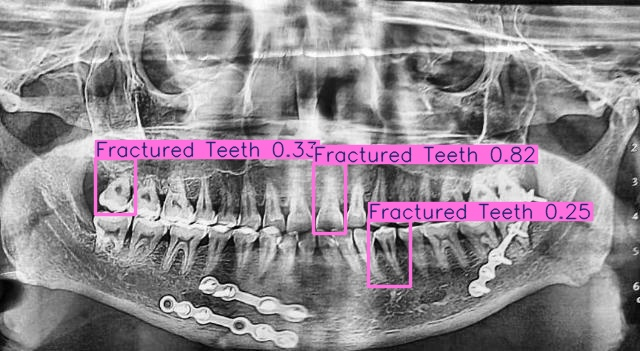

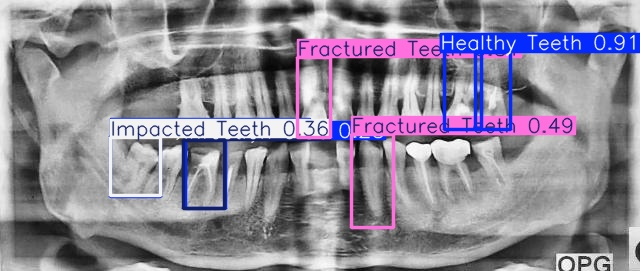

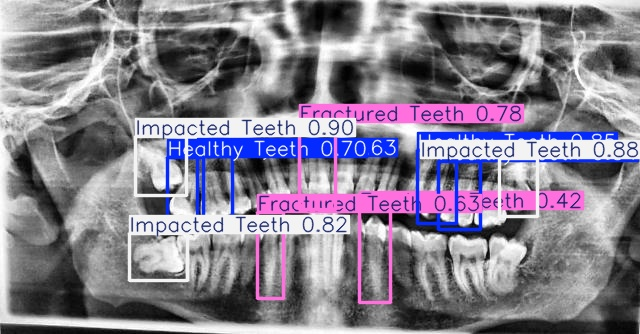

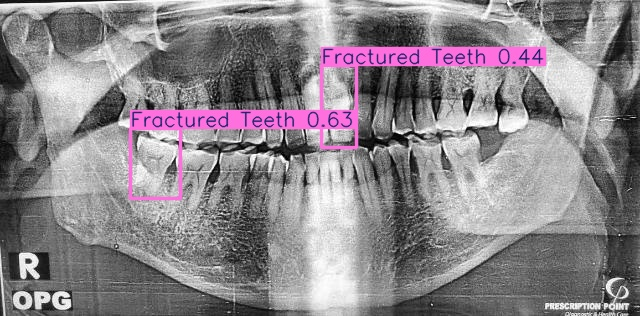

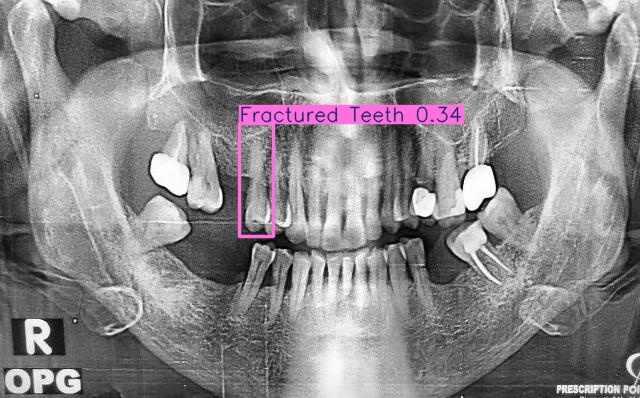

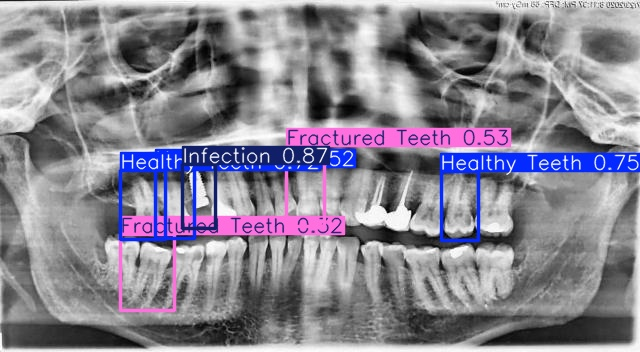

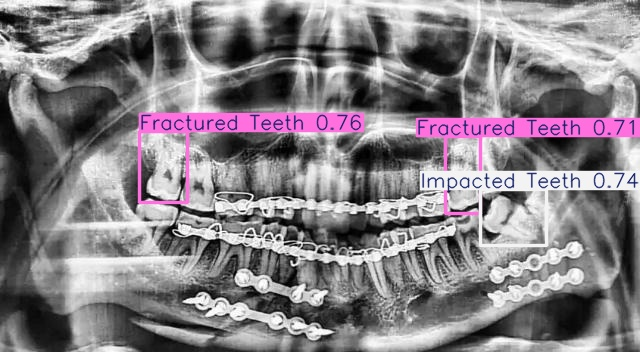

In [34]:
from IPython.display import Image, display

# Tahmin edilen görüntüleri sırayla göster
for img_path in images:
    display(Image(filename=img_path))


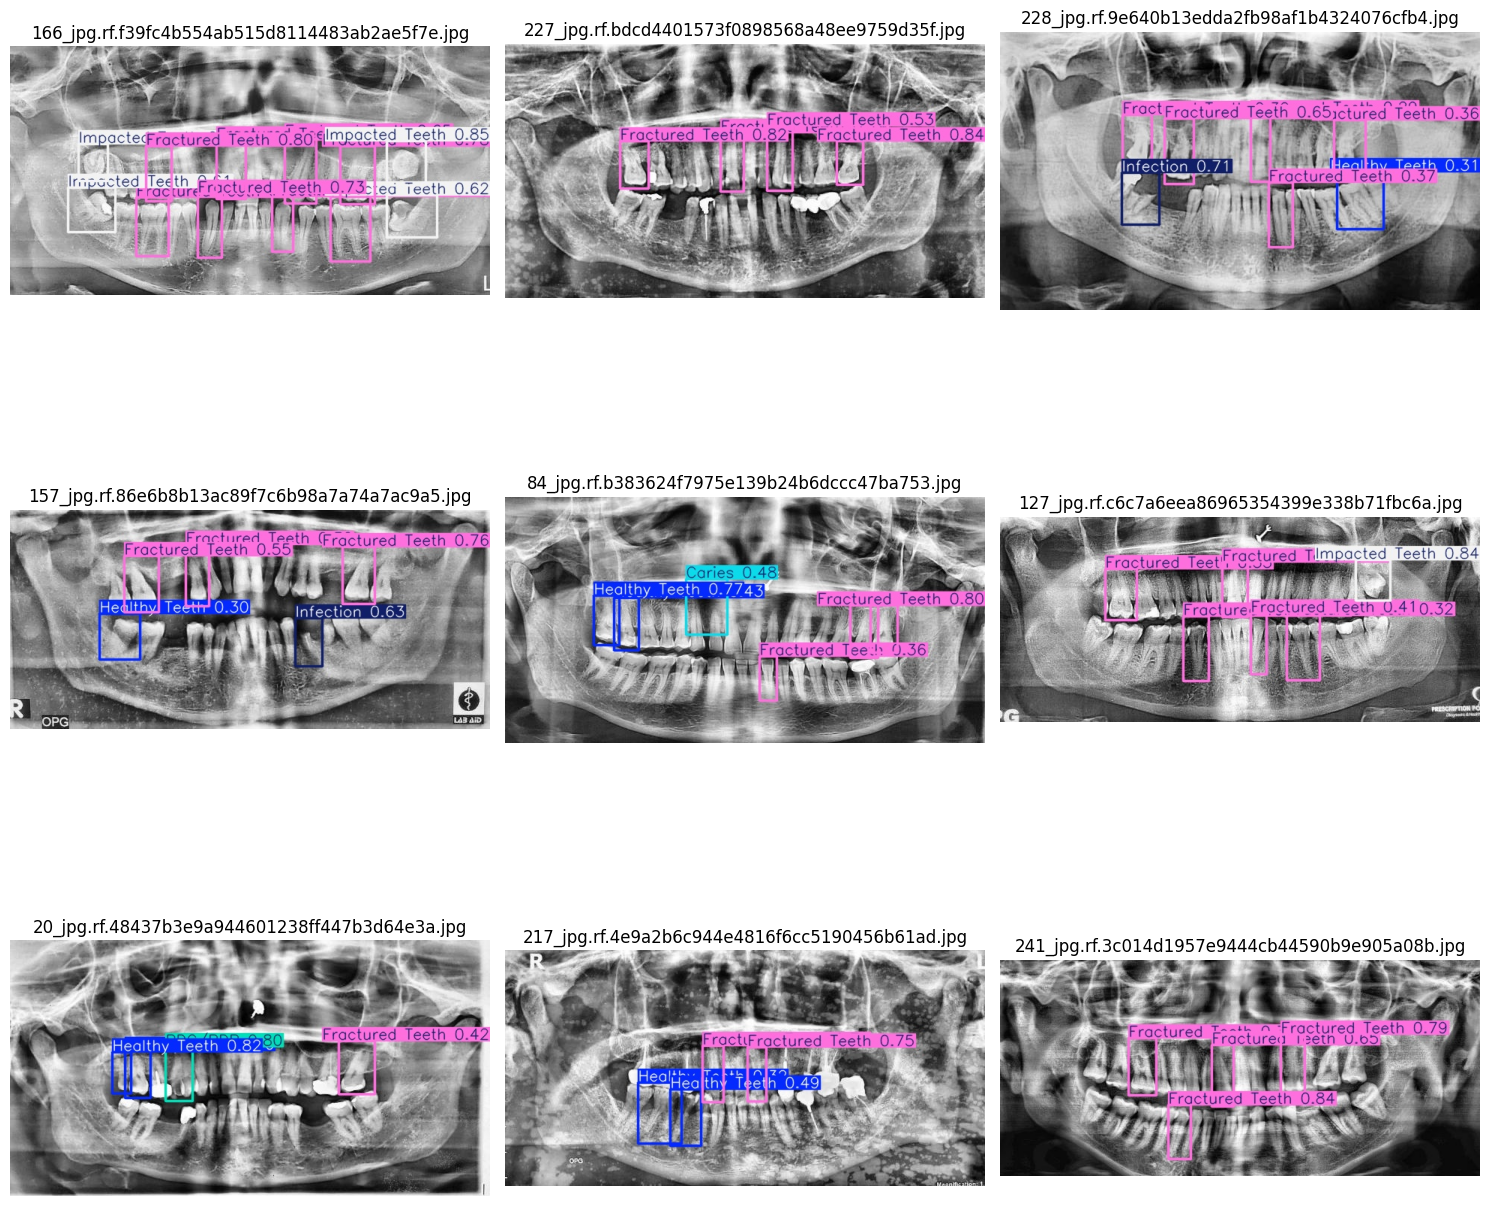

In [35]:
import matplotlib.pyplot as plt
import cv2

# Tahmin edilen görüntülerin ilk 9'unu yükle ve göster
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for img_path, ax in zip(images[:9], axes):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.split('/')[-1])

plt.tight_layout()
plt.show()
